In [1]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.2.0 --progress-bar off
!pip install -qqq langgraph==0.2.22 --progress-bar off

In [3]:

import sqlite3
import textwrap
from enum import Enum, auto
from typing import List, Literal, Optional, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

np.random.seed(42)

MODEL = "llama3-8b-8192"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("lama3"))

In [5]:

EDITOR_PROMPT = """
Rewrite for maximum social media engagement:

- Use attention-grabbing, concise language
- Inject personality and humor
- Optimize formatting (short paragraphs)
- Encourage interaction (questions, calls-to-action)
- Ensure perfect grammar and spelling
- Rewrite from first person perspective, when talking to an audience

Use only the information provided in the text. Think carefully."""

In [6]:

TWITTER_PROMPT = """
Generate a high-engagement tweet from the given text:
1. What problem does this solve?
2. Focus on the main technical points/features
3. Write a short, coherent paragraph (2-3 sentences max)
4. Use natural, conversational language
5. Optimize for virality: make it intriguing, relatable, or controversial
6. Exclude emojis and hashtags
"""

In [7]:

TWITTER_CRITIQUE_PROMPT = """
You are a Tweet Critique Agent. Your task is to analyze tweets and provide actionable feedback to make them more engaging. Focus on:

1. Clarity: Is the message clear and easy to understand?
2. Hook: Does it grab attention in the first few words?
3. Brevity: Is it concise while maintaining impact?
4. Call-to-action: Does it encourage interaction or sharing?
5. Tone: Is it appropriate for the intended audience?
6. Storytelling: Does it evoke curiosity?
7. Remove hype: Does it promise more than it delivers?

Provide 2-3 specific suggestions to improve the tweet's engagement potential.
Do not suggest hashtags. Keep your feedback concise and actionable.

Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

In [8]:

LINKEDIN_PROMPT = """
Write a compelling LinkedIn post from the given text. Structure it as follows:

1. Eye-catching headline (5-7 words)
2. Identify a key problem or challenge
3. Provide a bullet list of key benefits/features
4. Highlight a clear benefit or solution
5. Conclude with a thought-provoking question

Maintain a professional, informative tone. Avoid emojis and hashtags.
Keep the post concise (50-80 words) and relevant to the industry.
Focus on providing valuable insights or actionable takeaways that will resonate
with professionals in the field.
"""

In [9]:

LINKEDIN_CRITIQUE_PROMPT = """
Your role is to analyze LinkedIn posts and provide actionable feedback to make them more engaging.
Focus on the following aspects:

1. Hook: Evaluate the opening line's ability to grab attention.
2. Structure: Assess the post's flow and readability.
3. Content value: Determine if the post provides useful information or insights.
4. Call-to-action: Check if there's a clear next step for readers.
5. Language: Suggest improvements in tone, style, and word choice.
6. Visual elements: Recommend additions or changes to images, videos, or formatting.

For each aspect, provide:
- A brief assessment (1-2 sentences)
- A specific suggestion for improvement
- A concise example of the suggested change

Conclude with an overall recommendation for the most impactful change the author can make to increase engagement.
Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

In [10]:

class Post(BaseModel):
    """A post written in different versions"""

    drafts: List[str]
    feedback: Optional[str]


class AppState(TypedDict):
    user_text: str
    target_audience: str
    edit_text: str
    tweet: Post
    linkedin_post: Post
    n_drafts: int

In [11]:
def editor_node(state: AppState):
    prompt = f"""
text:
```
{state["user_text"]}
```
""".strip()
    response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
    return {"edit_text": response.content}

In [12]:

def tweet_writer_node(state: AppState):

    post = state["tweet"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
Tweet:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(TWITTER_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"tweet": post}


In [13]:
def linkedin_writer_node(state: AppState):
    post = state["linkedin_post"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
LinkedIn post:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(LINKEDIN_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"linkedin_post": post}

In [14]:
def critique_tweet_node(state: AppState):
    post = state["tweet"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested tweet (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(TWITTER_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"tweet": post}

In [15]:
def critique_linkedin_node(state: AppState):
    post = state["linkedin_post"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested LinkedIn post (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(LINKEDIN_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"linkedin_post": post}

In [16]:
def supervisor_node(state: AppState):
    return state

In [17]:
def should_rewrite(
    state: AppState,
) -> Literal[["linkedin_critique", "tweet_critique"], END]:
    tweet = state["tweet"]
    linkedin_post = state["linkedin_post"]
    n_drafts = state["n_drafts"]
    if len(tweet.drafts) >= n_drafts and len(linkedin_post.drafts) >= n_drafts:
        return END

    return ["linkedin_critique", "tweet_critique"]

In [18]:
graph = StateGraph(AppState)

graph.add_node("editor", editor_node)
graph.add_node("tweet_writer", tweet_writer_node)
graph.add_node("tweet_critique", critique_tweet_node)
graph.add_node("linkedin_writer", linkedin_writer_node)
graph.add_node("linkedin_critique", critique_linkedin_node)
graph.add_node("supervisor", supervisor_node)

graph.add_edge("editor", "tweet_writer")
graph.add_edge("editor", "linkedin_writer")

graph.add_edge("tweet_writer", "supervisor")
graph.add_edge("linkedin_writer", "supervisor")
graph.add_conditional_edges("supervisor", should_rewrite)

graph.add_edge("tweet_critique", "tweet_writer")
graph.add_edge("linkedin_critique", "linkedin_writer")

graph.set_entry_point("editor")

app = graph.compile()

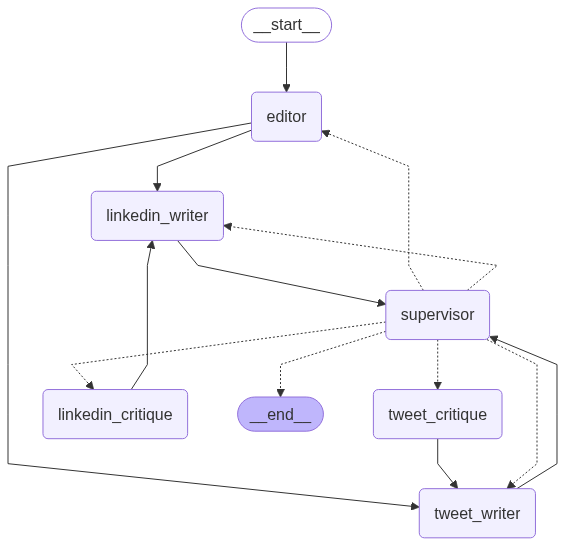

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:

%%time
config = {"configurable": {"thread_id": 42}}

user_text = """
With 22 billion parameters, Mistral Small v24.09 offers customers a convenient mid-point between Mistral NeMo 12B and Mistral Large 2,
providing a cost-effective solution that can be deployed across various platforms and environments.
The new small model delivers significant improvements in human alignment, reasoning capabilities, and code over the previous model.

Mistral-Small-Instruct-2409 is an instruct fine-tuned version with the following characteristics:

- 22B parameters
- Vocabulary to 32768
- Supports function calling
- 128k sequence length

Mistral Small v24.09 is released under the MRL license. You may self-deploy it for non-commercial purposes, using e.g. vLLM

Weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409
"""

state = app.invoke(
    {
        "user_text": user_text,
        "target_audience": "AI/ML engineers and researchers, Data Scientists",
        "tweet": Post(drafts=[], feedback=None),
        "linkedin_post": Post(drafts=[], feedback=None),
        "n_drafts": 3,
    },
    config=config,
)

CPU times: user 1.43 s, sys: 142 ms, total: 1.57 s
Wall time: 59.7 s


In [21]:

print(state["edit_text"])

Here's a rewritten version for maximum social media engagement:

Exciting News!

Meet Mistral Small v24.09, the game-changing AI model that's about to revolutionize the way you work!

With 22 billion parameters, this cost-effective solution is the perfect middle ground between Mistral NeMo 12B and Mistral Large 2. Deploy it across various platforms and environments with ease!

But that's not all! Mistral Small v24.09 boasts significant improvements in human alignment, reasoning capabilities, and code compared to its predecessor.

And, as an added bonus, the instruct fine-tuned version, Mistral-Small-Instruct-2409, comes with:

22B parameters
Vocabulary up to 32768
Function calling support
128k sequence length

The best part? You can self-deploy it for non-commercial purposes using vLLM!

Ready to get started? Check out the weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409

What are you waiting for? Share your thoughts and let's get the conversatio

In [22]:

for i, draft in enumerate(state["tweet"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(textwrap.fill(draft, 80))
    print()

Draft #1
----------
Here's a rewritten version of the text for a high-engagement tweet:  "Meet
Mistral Small v24.09, the AI model that's about to revolutionize the way you
work. With 22 billion parameters, this cost-effective solution offers a sweet
spot between Mistral NeMo 12B and Mistral Large 2. Plus, it boasts significant
improvements in human alignment, reasoning capabilities, and code. And the best
part? You can self-deploy it for non-commercial purposes using vLLM. Check out
the weights on HuggingFace hub and let's get the conversation started!"

Draft #2
----------
Here's a rewritten version of the tweet:  "Get ready to transform your workflow
with Mistral Small v24.09, the AI model that's about to revolutionize the way
you work! With 22 billion parameters, this cost-effective solution is the
perfect middle ground between two of our most popular models - and it's more
affordable! Plus, it boasts significant improvements in human alignment,
reasoning capabilities, and code. Dep

In [23]:

print(state["tweet"].feedback)


Here's a critique of the rewritten tweet:

**Strengths:**

* The tweet is concise and easy to understand, making it clear what Mistral Small v24.09 is and its benefits.
* It includes a clear call-to-action ("Check out the weights on HuggingFace hub and let's get the conversation started!") to encourage engagement.
* The tone is professional and suitable for the target audience.

**Weaknesses:**

* The tweet could be more attention-grabbing. The opening phrase "Get ready to transform your workflow" is a good start, but it could be more specific and surprising.
* The tweet could benefit from a more compelling reason to care about Mistral Small v24.09. What specific problems does it solve, and how will it make a tangible impact on the audience's work?

**Suggestions:**

1. **Add a hook:** Instead of starting with a generic phrase, try to start with something that grabs the audience's attention. For example, "Did you know that Mistral Small v24.09 can reduce AI model deployment time by 50%

In [24]:
for i, draft in enumerate(state["linkedin_post"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(draft)
    print()

Draft #1
----------
Here is the rewritten LinkedIn post:

"Revolutionizing AI: Introducing Mistral Small v24.09"

Are you tired of sacrificing performance for cost-effectiveness in AI models? Mistral Small v24.09 offers a game-changing solution, boasting 22 billion parameters, human alignment, and reasoning capabilities. Key benefits include:

• Cost-effective solution
• Easy deployment across platforms and environments
• Significant improvements in human alignment and reasoning capabilities
• Instruct fine-tuned version with 22B parameters, vocabulary up to 32768, function calling support, and 128k sequence length

What sets Mistral Small v24.09 apart is its ability to be self-deployed for non-commercial purposes using vLLM. Ready to get started? Check out the weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409

What do you think is the most exciting aspect of this new AI model? Share your thoughts and let's get the conversation started!

Draft #2


In [25]:

print(state["linkedin_post"].feedback)

Here's the critique of the rewritten LinkedIn post:

**Hook:** The opening line "Unlock the Power of AI: Introducing Mistral Small v24.09, the Game-Changer You've Been Waiting For!" is attention-grabbing and relevant to the target audience.

**Suggestion:** Consider adding a brief statistic or a surprising fact about the AI model to make it even more intriguing.

Example: "Unlock the Power of AI: Introducing Mistral Small v24.09, the Game-Changer You've Been Waiting For! Did you know that this AI model can process 22 billion parameters, making it 10x more efficient than its predecessor?"

**Structure:** The post is well-structured, with clear headings and bullet points that make it easy to read and understand.

**Suggestion:** Consider adding a brief summary or conclusion at the end to summarize the key benefits and encourage readers to try out the AI model.

Example: "In summary, Mistral Small v24.09 is a game-changing AI model that offers a cost-effective solution with significant im